In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))
import warnings 
warnings.filterwarnings('ignore')

Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Sklearn: 0.23.2
Matplotlib: 3.3.2
NumPy: 1.18.5


In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [3]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))


Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [4]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

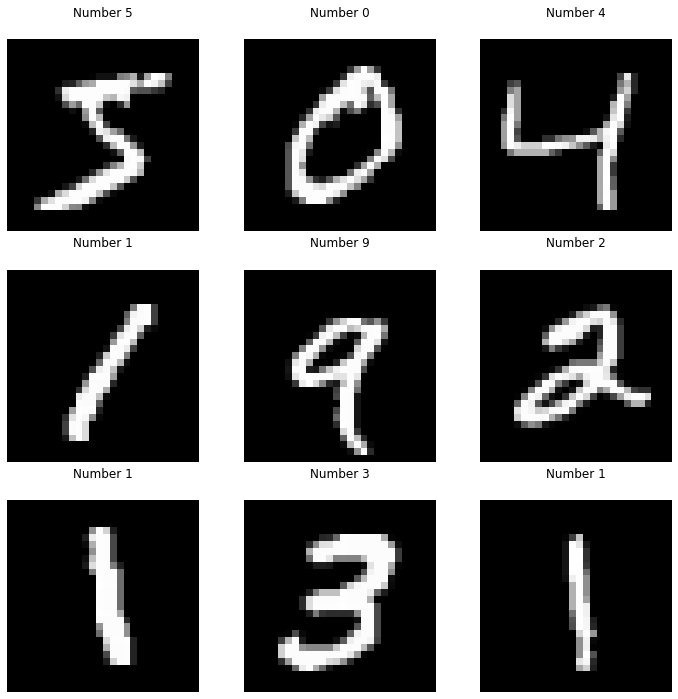

In [5]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()


In [6]:

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [7]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [8]:
kmeans.labels_

array([1, 4, 5, ..., 1, 8, 6])

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [10]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])


[5 0 4 1 9 2 5 3 1 7 3 1 3 6 1 7 2 7 5 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [11]:
import sklearn.metrics as metrics
def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [12]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))


Number of Clusters: 10
Inertia: 2369097.5152816772
Homogeneity: 0.49489582576701824
Accuracy: 0.5982666666666666

Number of Clusters: 16
Inertia: 2236064.6373364246
Homogeneity: 0.5250638004180579
Accuracy: 0.5852666666666667

Number of Clusters: 36
Inertia: 1960847.7278194414
Homogeneity: 0.6958473958707588
Accuracy: 0.77355

Number of Clusters: 64
Inertia: 1816843.5806190192
Homogeneity: 0.7302742338019582
Accuracy: 0.7938166666666666

Number of Clusters: 144
Inertia: 1632142.4067893159
Homogeneity: 0.7978543120282343
Accuracy: 0.8633

Number of Clusters: 256
Inertia: 1514398.1126815164
Homogeneity: 0.8363520748994111
Accuracy: 0.8893666666666666



In [13]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9035



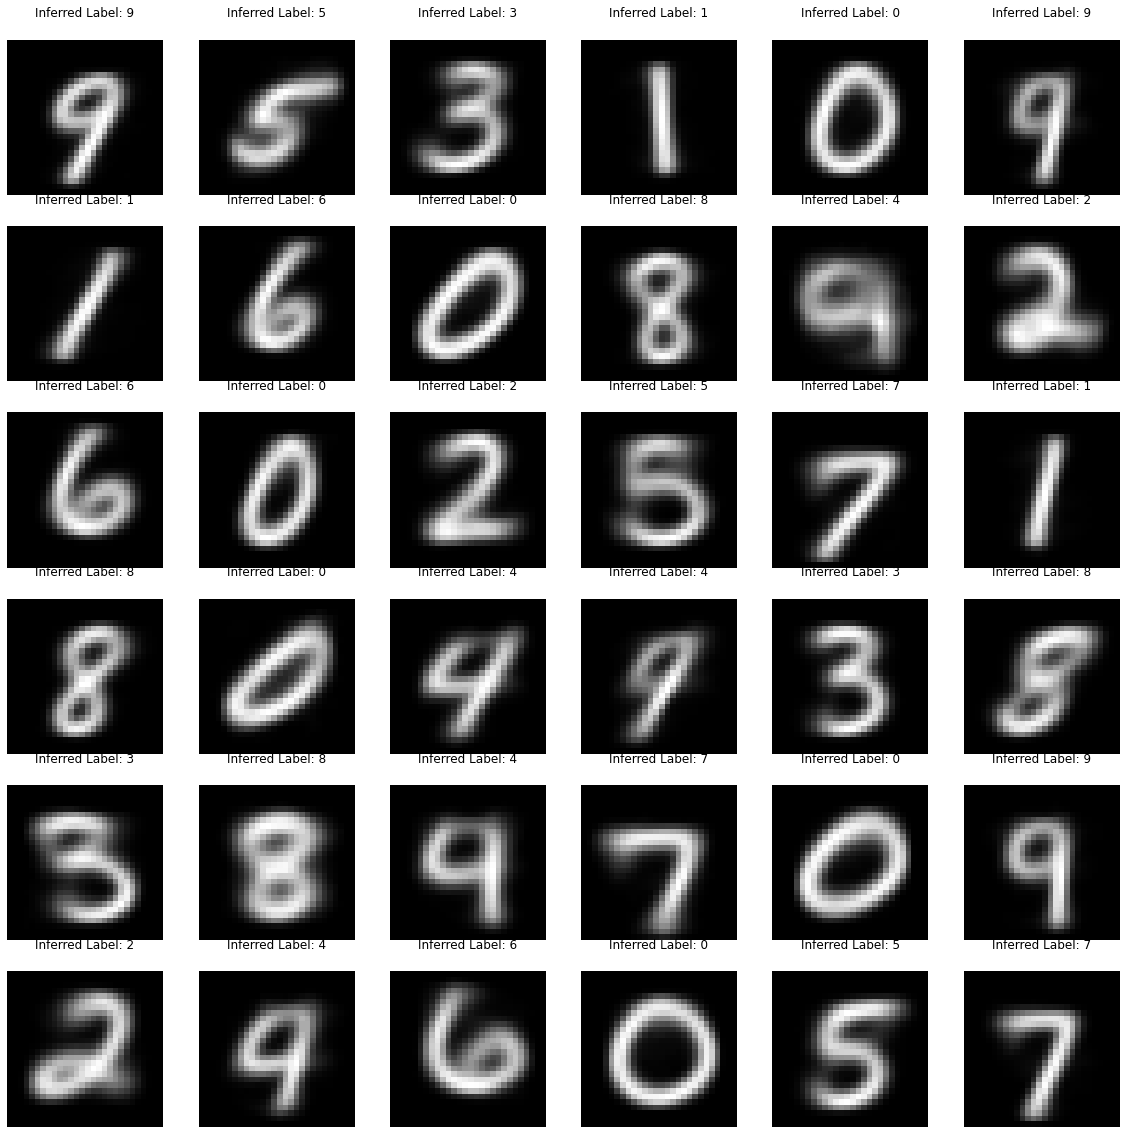

In [14]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
# display the figure
fig.show()  

In [15]:
#https://github.com/Yuvrajchopra25/Project-5-MNIST-Handwritten-Digit-Recognition-using-Sklearn-and-LogisticRegression/blob/master/MNIST%20Handwritten%20Digit%20Recognition%20using%20Sklearn%20and%20LogisticRegression.ipynb
#logistic regression
X.shape

(60000, 784)

In [16]:
Y.shape

(60000,)

In [17]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) # Lets reshape it to plot it


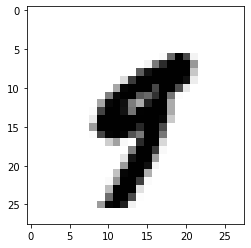

In [18]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

In [19]:
Y[36000]

9

In [20]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [21]:
# shuffling of data in some random order
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], Y_train[shuffle_index]

In [22]:
#Creating a detector for number 2

In [23]:
# convert string to numbers
Y_train = Y_train.astype(np.int)
Y_test = Y_test.astype(np.int)

Y_train_2 = (Y_train==2)
Y_test_2 = (Y_test==2)

In [24]:
Y_train_2

array([False, False, False, ..., False, False, False])

In [25]:
Y_test_2

array([], dtype=bool)

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
clf = LogisticRegression(tol = 0.1)

In [29]:
clf.fit(X_train, Y_train_2)

LogisticRegression(tol=0.1)

In [30]:
clf.predict([some_digit])

array([False])

In [31]:
from sklearn.model_selection import cross_val_score
a = cross_val_score(clf, X_train, Y_train_2, cv = 3, scoring = "accuracy")

In [32]:
a.mean()

0.9007